# Plotting PyPSA results (simplified version 4-nodes clustering and 1 year data - Bolivia)

In [1]:
###### algunas cosas cambian si pongo como comentarios en el import de geoviews y hvplot (liberias conflictivas?)

import logging
import os

import pypsa
import yaml
import pandas as pd
import geopandas as gpd
#import geoviews as gv
#import hvplot.pandas 
import numpy as np
import scipy as sp
import networkx as nx

# plotting stuff
import matplotlib.pyplot as plt

plt.style.use("bmh")
import seaborn as sns  ###
import cartopy.crs as ccrs

sns.set(style="darkgrid")

from scipy.sparse import csgraph
from itertools import product

from shapely.geometry import Point, LineString
import shapely, shapely.prepared, shapely.wkt

logger = logging.getLogger(__name__)

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", 70)

import sys

sys.path.append("../")  # to import helpers
from scripts._helpers import sets_path_to_root

sets_path_to_root("pypsa-earth")

max_node_size = 1.0  # maximum size of a node for plotting purposes [used in plots]

This is the repository path:  c:\Users\Lenovo\Desktop\pypsa-earth
Had to go 1 folder(s) up.


In [2]:
# utility function for nice plotting

def normalize_node_size(values, max_node_size=max_node_size):
    return values / values.max() * max_node_size

# Load all networks

In [3]:
# add_electricity_network = os.getcwd() + '/networks/elec.nc'
# n_add_el = pypsa.Network(add_electricity_network)

# clustered_network = os.getcwd() + '/networks/elec_s_20.nc'
# n_cluster = pypsa.Network(clustered_network)



#Se carga el documento (o la direccion/path del mismo) a una variable (solved_network)

solved_network = os.getcwd() + "/results/networks/elec_s_4_ec_lcopt_Co2L-1H.nc"

base_network= os.getcwd() +  "/networks/base.nc"

#Se cargan los resultados de la optimizacion del problema segun las caracteristicas definidas para el modelo en n_solve con la funcion (operador?) Network de pypsa

n_base= pypsa.Network(base_network)

n_solve = pypsa.Network(solved_network)

INFO:pypsa.io:Imported network base.nc has buses, lines, transformers
INFO:pypsa.io:Imported network elec_s_4_ec_lcopt_Co2L-1H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


# Base network

In [4]:
n_base

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 155
 - Line: 161
 - Transformer: 39
Snapshots: 8760

(<matplotlib.collections.PatchCollection at 0x1fad05fd5d0>,
 <matplotlib.collections.LineCollection at 0x1fad06e2a10>)

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


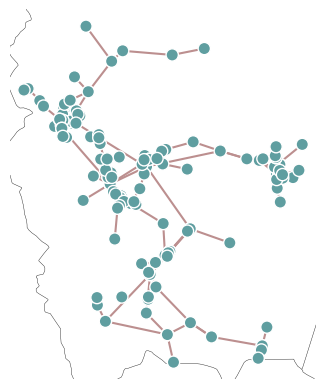

In [5]:
n_base.plot()

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


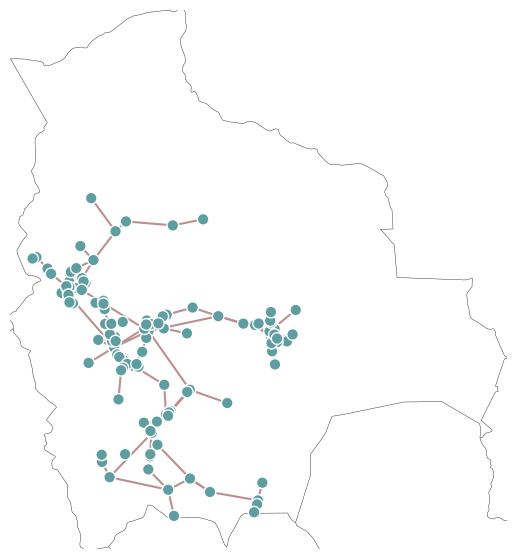

In [6]:
import matplotlib.pyplot as plt
import pypsa
import numpy as np
import cartopy.crs as ccrs

#countries = ["Bolivia"]

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

n_base.plot(ax=ax)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


### Conections between buses 

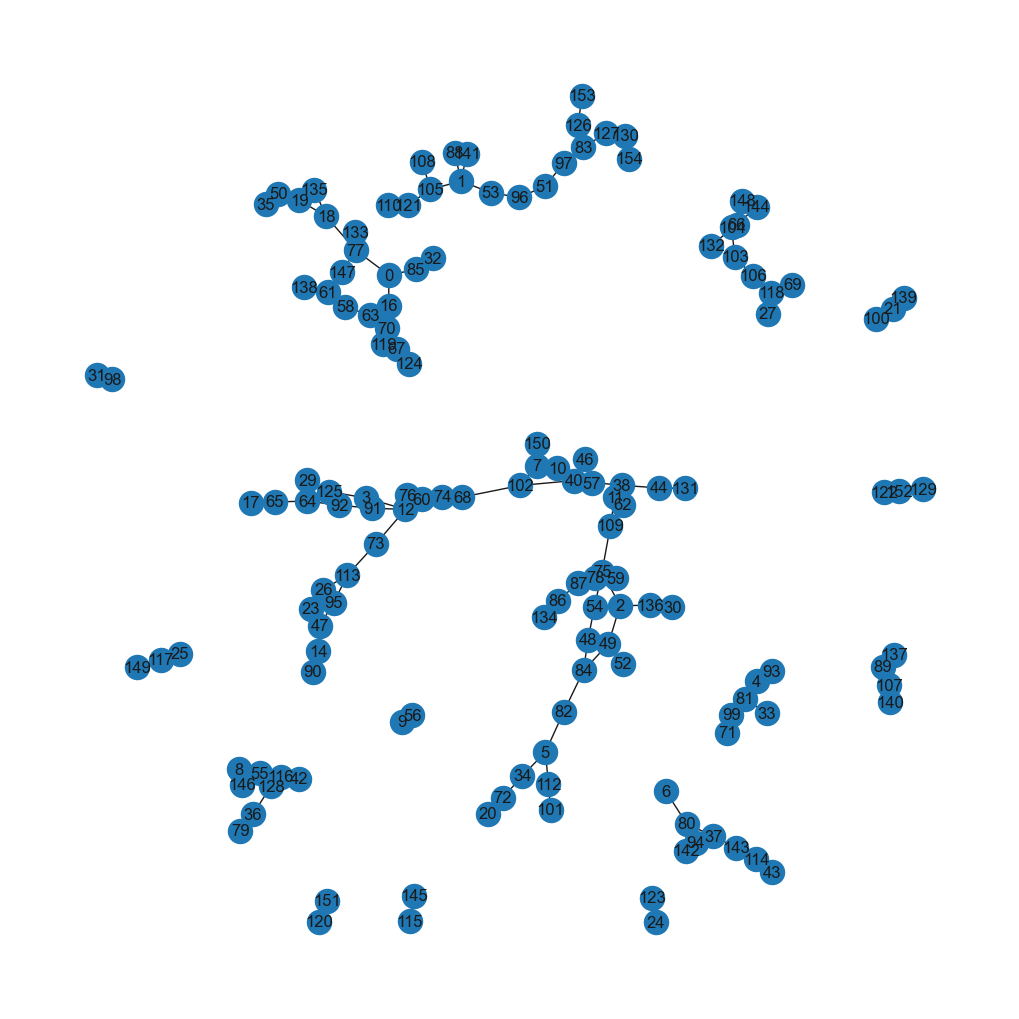

In [7]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

G = nx.Graph()


df_lines = pd.read_csv("C:/Users/Lenovo/Desktop/pypsa-earth/resources/base_network/all_lines_build_network.csv")

df_buses = pd.read_csv("C:/Users/Lenovo/Desktop/pypsa-earth/resources/base_network/all_buses_build_network.csv")

options = {
    'node_color': 'black',
    'node_size': 2,
    'width': 3,
}

df1 = df_lines[["bus0", "bus1"]]
df2 = df_buses[["lon", "lat"]]

G = nx.from_pandas_edgelist(df1, 'bus0', 'bus1')

pos = nx.spring_layout(G, scale=2, seed=84)

for i in range(len(df_buses)):
    pos[i] = [df_buses.lon[i], df_buses.lat[i]]



pos = nx.shell_layout(G)

plt.figure(figsize=(10, 10))
fig1 = nx.draw(G, with_labels=True)

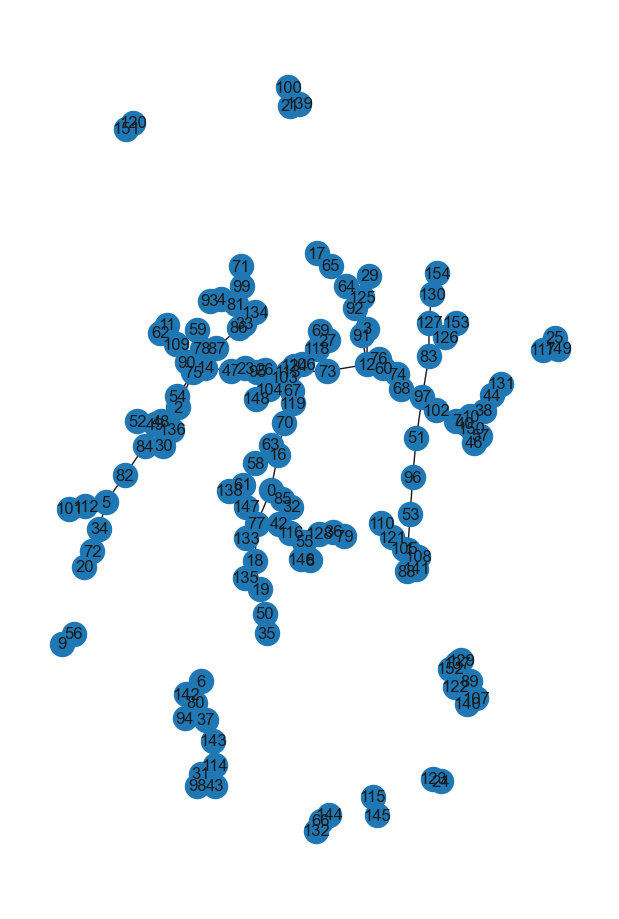

In [8]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

G = nx.Graph()


df_lines = pd.read_csv("C:/Users/Lenovo/Desktop/pypsa-earth/resources/base_network/all_lines_build_network.csv")

df_buses = pd.read_csv("C:/Users/Lenovo/Desktop/pypsa-earth/resources/base_network/all_buses_build_network.csv")

options = {
    'node_color': 'black',
    'node_size': 1,
    'width': 1,
}

df1 = df_lines[["bus0", "bus1"]]
df2 = df_buses[["lon", "lat"]]

G = nx.from_pandas_edgelist(df1, 'bus0', 'bus1')

pos = nx.spring_layout(G, scale=2, seed=84)

for i in range(len(df_buses)):
    node_id = i
    latitude = df_buses.lat[i]
    longitude = df_buses.lon[i]
    pos[node_id] = [latitude, longitude]



pos = nx.shell_layout(G)

plt.figure(figsize=(6, 9))
fig1 = nx.draw(G, with_labels=True)

# Solved network

### General info

In [9]:
n = n_solve
n

PyPSA Network
Components:
 - Bus: 12
 - Carrier: 16
 - Generator: 23
 - GlobalConstraint: 1
 - Line: 3
 - Link: 16
 - Load: 4
 - StorageUnit: 3
 - Store: 8
Snapshots: 8760

In [10]:
# ".global_constraints" muestra las restricciones consideradas para el modelo (en el config.yaml solo se tomo en cuenta el limite de emisiones) tonCO2/year

n.global_constraints

,sense,constant,type,investment_period,carrier_attribute,mu
GlobalConstraint,,,,,,
CO2Limit,<=,77500000.0,primary_energy,NaN,co2_emissions,0.0


In [11]:
# estimation of the total emissions from the system in MtonCO2:

emissions = n.generators_t.p / n.generators.efficiency * n.generators.carrier.map(n.carriers.co2_emissions) # t/h

#snapshot_weightings provides the number of agregation used for each time step considered (4 hours in this case) and @ ins a multiplier
n.snapshot_weightings.generators @ emissions.sum(axis=1).div(1e6) # Mt


2.1024411923371433

In [12]:
##### check why the value does not appear 
#   - It seems that while the model run before, due to restrictions on simulation, proper solving wasn't possible (by increasing tolerances of the solver the model gets actual results)
# Eur/Year

n.objective

50551042.94626501

In [13]:
# Calculo del precio promedio de energia promedio en la red (costo total de operacion)
# Costo promedio de energia = (costos acumulados durante el periodo de analisis) /  [(sumatoria de las cargas variables en el tiempo)*(horas consideradas en cada time frame)

print("Costo total " + str(n.objective))
print("demanda total " + str(n.loads_t.p.sum().sum()*1))

(n.objective)/(n.loads_t.p.sum().sum()*1)

Costo total 50551042.94626501
demanda total 9217867.62726675


5.484027867435783

In [14]:
#promedio del costo marginal en los buses y a lo largo del año

n.buses_t.marginal_price.mean(axis = 1).mean()   ####   .plot(kind = "area")

13.321107938535816

In [15]:
n.buses_t

{'v_mag_pu_set': Empty DataFrame
 Columns: []
 Index: [2013-01-01 00:00:00, 2013-01-01 01:00:00, 2013-01-01 02:00:00, 2013-01-01 03:00:00, 2013-01-01 04:00:00, 2013-01-01 05:00:00, 2013-01-01 06:00:00, 2013-01-01 07:00:00, 2013-01-01 08:00:00, 2013-01-01 09:00:00, 2013-01-01 10:00:00, 2013-01-01 11:00:00, 2013-01-01 12:00:00, 2013-01-01 13:00:00, 2013-01-01 14:00:00, 2013-01-01 15:00:00, 2013-01-01 16:00:00, 2013-01-01 17:00:00, 2013-01-01 18:00:00, 2013-01-01 19:00:00, 2013-01-01 20:00:00, 2013-01-01 21:00:00, 2013-01-01 22:00:00, 2013-01-01 23:00:00, 2013-01-02 00:00:00, 2013-01-02 01:00:00, 2013-01-02 02:00:00, 2013-01-02 03:00:00, 2013-01-02 04:00:00, 2013-01-02 05:00:00, 2013-01-02 06:00:00, 2013-01-02 07:00:00, 2013-01-02 08:00:00, 2013-01-02 09:00:00, 2013-01-02 10:00:00, 2013-01-02 11:00:00, 2013-01-02 12:00:00, 2013-01-02 13:00:00, 2013-01-02 14:00:00, 2013-01-02 15:00:00, 2013-01-02 16:00:00, 2013-01-02 17:00:00, 2013-01-02 18:00:00, 2013-01-02 19:00:00, 2013-01-02 20:00:00, 

### Spatial temporal resolution

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


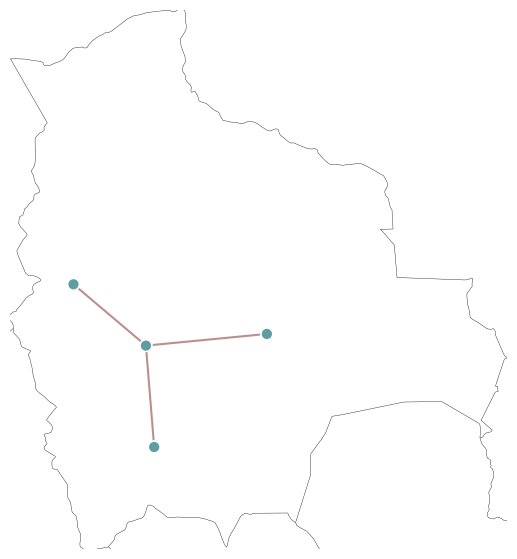

In [16]:
#Resultado grafico de la red electrica ideal (lineas verdes representan expansiones de la red)

#####beacuase all buses are not connected it might be that the problem is not fully solved 
# - Lines used in the model don't consider newer power lines (data bases were not apdated)
# - This is proved by comparing raw lines (all available lines in OSM) and clean lines (processed lines to be used in the model)
# - A linker is required to include new/additional data into the "all_clean_lines.geojson"

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(figsize=(7, 7),subplot_kw={'projection': ccrs.PlateCarree()})

n.plot(ax=ax)
ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


In [17]:
n.buses

,v_nom,country,x,y,control,generator,carrier,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,
BO 0,220.0,BO,-66.283881,-17.925590,Slack,BO 0 OCGT,AC,,None,1.0,0.0,inf,
BO 1,220.0,BO,-66.083608,-20.391908,PQ,,AC,,None,1.0,0.0,inf,
BO 2,220.0,BO,-63.342093,-17.641643,PQ,,AC,,None,1.0,0.0,inf,
BO 3,220.0,BO,-68.046138,-16.434300,PQ,,AC,,None,1.0,0.0,inf,
BO 0 H2,1.0,BO,-66.283881,-17.925590,Slack,,H2,,None,1.0,0.0,inf,
BO 1 H2,1.0,BO,-66.083608,-20.391908,Slack,,H2,,None,1.0,0.0,inf,
BO 2 H2,1.0,BO,-63.342093,-17.641643,Slack,,H2,,None,1.0,0.0,inf,
BO 3 H2,1.0,BO,-68.046138,-16.434300,Slack,,H2,,None,1.0,0.0,inf,
BO 0 battery,1.0,BO,-66.283881,-17.925590,Slack,,battery,,None,1.0,0.0,inf,


In [18]:
#Se muestra el tamaño de la resolucion temporal del modelo - timesteps 
# - Currently the system is working with a toy version of Bolivia to allow faster solving times (4h time aggregation and a little over 5 months acoording the rules in the config.yaml file) 
# - A more complete model should be run eventually with different conditions (higher time resolution) or methods like tsam (https://tsam.readthedocs.io/en/latest/mathematicalBackgroundDoc.html)
#  

len(n.snapshots)

8760

### Overview components

In [19]:
#Imprimir la lista de componentes considerados en el dataframe creado

for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 12 entries
Component 'Carrier' has 16 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 3 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 16 entries
Component 'Load' has 4 entries
Component 'Generator' has 23 entries
Component 'StorageUnit' has 3 entries
Component 'Store' has 8 entries


### Energy balance

In [20]:
# ".stores_t" hace referencia a la energia que se puede almacenar en un bus (se usa para definir otras tecnologias como storage)
# - https://pypsa.readthedocs.io/en/latest/components.html#store

n.stores_t.p.sum()

Store
BO 0 H2         0.0
BO 1 H2         0.0
BO 2 H2         0.0
BO 3 H2         0.0
BO 0 battery    0.0
BO 1 battery    0.0
BO 2 battery    0.0
BO 3 battery    0.0
dtype: float64

In [21]:
n.stores_t.p.sum().sum()

0.0

In [22]:
# se imprimen todos los generadores considerados en el modelo

##### check if loadshedding is being used in the config.yaml file, at the solving section 
# - load shedding is represented in the model by the inclution on additional "load" generation/generators 

n.generators

print(type(n.generators))
print(n.generators.columns)
n.generators.head()

<class 'pandas.core.frame.DataFrame'>
Index(['p_nom_max', 'weight', 'p_nom', 'capital_cost', 'efficiency',
       'p_nom_min', 'marginal_cost', 'carrier', 'p_nom_extendable', 'bus',
       'control', 'p_nom_opt', 'sign', 'build_year', 'min_up_time',
       'min_down_time', 'up_time_before', 'down_time_before', 'type',
       'p_min_pu', 'p_max_pu', 'p_set', 'q_set', 'lifetime', 'committable',
       'start_up_cost', 'shut_down_cost', 'ramp_limit_up', 'ramp_limit_down',
       'ramp_limit_start_up', 'ramp_limit_shut_down'],
      dtype='object')


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,p_nom_extendable,bus,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,149.91,47234.561404,0.39,149.91,14.395011,OCGT,False,BO 0,Slack,149.91,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,4.172096e+05,15333.980338,26.54,109295.569252,1.00,26.54,0.024710,onwind,True,BO 0,,26.54,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 ror,inf,132.320000,132.32,270940.715283,0.90,0.00,0.010533,ror,False,BO 0,,132.32,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,5.343396e+05,101918.461617,50.20,50855.958267,1.00,50.20,0.019637,solar,True,BO 0,,50.20,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 CCGT,inf,0.000000,454.30,84469.122809,0.50,454.30,12.890424,CCGT,False,BO 1,,454.30,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [23]:
#Imprimir solo los generadores de Bolivia

########this is only necessary if several countries are studied at the same time

idx = ['BO' in x for x in n.generators.index]
n.generators.loc[idx,:].head()

,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,carrier,p_nom_extendable,bus,control,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,type,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 OCGT,inf,0.000000,149.91,47234.561404,0.39,149.91,14.395011,OCGT,False,BO 0,Slack,149.91,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 onwind,4.172096e+05,15333.980338,26.54,109295.569252,1.00,26.54,0.024710,onwind,True,BO 0,,26.54,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 ror,inf,132.320000,132.32,270940.715283,0.90,0.00,0.010533,ror,False,BO 0,,132.32,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 0 solar,5.343396e+05,101918.461617,50.20,50855.958267,1.00,50.20,0.019637,solar,True,BO 0,,50.20,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0
BO 1 CCGT,inf,0.000000,454.30,84469.122809,0.50,454.30,12.890424,CCGT,False,BO 1,,454.30,1.0,0,0,0,1,0,,0.0,1.0,0.0,0.0,inf,False,0.0,0.0,NaN,NaN,1.0,1.0


In [24]:
#Imprimir la suma de potencias nominales de los generadores de Bolivia

idx = ['BO' in x for x in n.generators.index]

print(n.generators.loc[idx,:].p_nom.sum())
print(n.generators.loc[idx,:].p_nom_opt.sum())

4000002884.2
4000002884.2000093


In [25]:
# Difference between total load and generation
# losses = n.stores_t

n.generators_t.p.sum().sum() - n.loads_t.p.sum().sum()  # - substract storage losses


-1300479.49794944

### Total installed generator capacity

In [26]:
gen_cap = n.generators.groupby(["carrier"]).sum()
# gen_cap.to_csv('capacities_by_carrier.csv',index=False)
gen_cap


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_17684\278006981.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gen_cap = n.generators.groupby(["carrier"]).sum()


,p_nom_max,weight,p_nom,capital_cost,efficiency,p_nom_min,marginal_cost,p_nom_extendable,p_nom_opt,sign,build_year,min_up_time,min_down_time,up_time_before,down_time_before,p_min_pu,p_max_pu,p_set,q_set,lifetime,committable,start_up_cost,shut_down_cost,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
carrier,,,,,,,,,,,,,,,,,,,,,,,,,,,
CCGT,NaN,0.000000,1.363990e+03,168938.245618,1.000,1363.99,25.780506,0,1.363990e+03,2.000,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
OCGT,NaN,0.000000,9.489200e+02,141703.684213,1.170,948.92,43.185155,0,9.489200e+02,3.000,0,0,0,3,0,0.0,3.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,3.0,3.0
biomass,NaN,0.000000,5.558000e+01,556030.719012,0.936,55.58,29.935028,2,5.558000e+01,2.000,0,0,0,2,0,0.0,2.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,2.0,2.0
load,NaN,0.000000,4.000000e+09,0.000000,4.000,0.00,4.039883,0,4.000000e+09,0.004,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0
oil,inf,0.000000,1.174000e+01,38234.561404,0.393,11.74,130.235943,0,1.174000e+01,1.000,0,0,0,1,0,0.0,1.0,0.0,0.0,inf,0,0.0,0.0,0.0,0.0,1.0,1.0
onwind,2.375876e+06,160337.867797,2.654000e+01,437182.277006,4.000,26.54,0.098912,4,2.654000e+01,4.000,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0
ror,NaN,362.530000,3.625300e+02,812822.145848,2.700,0.00,0.030747,0,3.625300e+02,3.000,0,0,0,3,0,0.0,3.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,3.0,3.0
solar,1.869809e+06,330825.566632,1.149000e+02,203423.833068,4.000,114.90,0.078855,4,1.149000e+02,4.000,0,0,0,4,0,0.0,4.0,0.0,0.0,NaN,0,0.0,0.0,0.0,0.0,4.0,4.0


In [27]:
n.stores_t.p.head()

Store,BO 0 H2,BO 1 H2,BO 2 H2,BO 3 H2,BO 0 battery,BO 1 battery,BO 2 battery,BO 3 battery
snapshot,,,,,,,,
2013-01-01 00:00:00,2.581058e-11,-7.270034e-12,2.504911e-11,5.191041e-11,1.776967e-11,-2.778974e-11,-6.934040e-12,7.391826e-12
2013-01-01 01:00:00,2.120682e-11,-3.380112e-12,2.532865e-11,4.711383e-11,1.700744e-11,-3.600823e-11,-6.797352e-12,1.457943e-12
2013-01-01 02:00:00,9.805766e-12,7.410936e-12,2.793755e-11,3.861765e-11,-1.986610e-11,-2.242575e-11,4.393782e-14,-2.193125e-11
2013-01-01 03:00:00,2.798832e-12,2.669566e-11,3.092855e-11,3.647973e-11,-3.280137e-11,3.666477e-11,8.798287e-12,-1.382454e-11
2013-01-01 04:00:00,3.441637e-12,2.960489e-11,3.142237e-11,3.744304e-11,-2.047107e-11,8.011829e-12,1.599287e-12,-1.331197e-11


<AxesSubplot:xlabel='snapshot'>

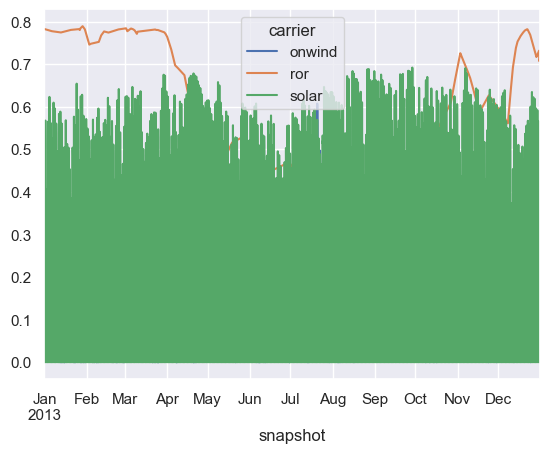

In [28]:
n.generators_t.p_max_pu.groupby(n.generators.carrier, axis=1).mean().plot()

<AxesSubplot:xlabel='snapshot'>

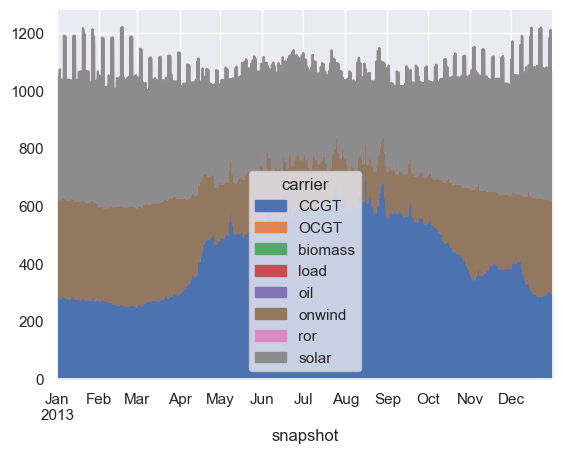

In [29]:
#excluded_carrier = 'load'
#grouped_mean = n.generators_t.p.groupby(n.generators.carrier, axis=1).mean().drop(columns=excluded_carrier)
#grouped_mean.plot(kind='line')

n.generators_t.p.groupby(n.generators.carrier, axis=1).sum().plot(kind = "area")

<AxesSubplot:xlabel='snapshot'>

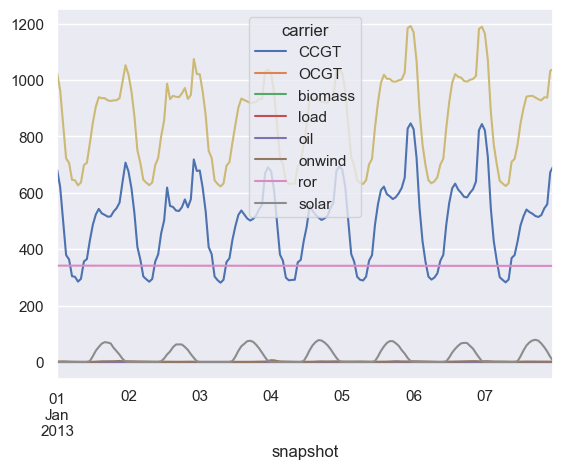

In [30]:
#n.generators_t.p.loc["2013-01-01":"2013-01-07",:].plot()
#n.generators_t.p.loc["2013-01-01":"2013-01-07",:].groupby(n.generators.carrier, axis=1).mean().plot()

n.generators_t.p.loc["2013-01-01":"2013-01-07",:].groupby(n.generators.carrier, axis=1).sum().plot(kind = "line")

n.generators_t.p.loc["2013-01-01":"2013-01-07",:].groupby(n.generators.carrier, axis=1).sum().sum(axis=1).plot(kind = "line")



In [31]:
# If 0, all renewable capacity potential is used
n.generators.p_nom_max.sum() - n.generators.p_nom_opt.sum()

inf

In [32]:
n.loads_t.p.sum().sum()

9217867.62726675

In [33]:
n.generators_t.p.sum().sum()

7917388.12931731

In [34]:
#### pq la multiplicacion?

n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom.sum()

bus   carrier
BO 0  OCGT       1.499100e+02
      load       1.000000e+09
      onwind     2.654000e+01
      ror        1.323200e+02
      solar      5.020000e+01
BO 1  CCGT       4.543000e+02
      load       1.000000e+09
      onwind     0.000000e+00
      ror        1.904000e+01
      solar      6.470000e+01
BO 2  CCGT       9.096900e+02
      OCGT       7.497600e+02
      biomass    5.064000e+01
      load       1.000000e+09
      onwind     0.000000e+00
      solar      0.000000e+00
BO 3  OCGT       4.925000e+01
      biomass    4.940000e+00
      load       1.000000e+09
      oil        1.174000e+01
      onwind     0.000000e+00
      ror        2.111700e+02
      solar      0.000000e+00
Name: p_nom, dtype: float64

### Lines

In [35]:
n.lines

,bus0,bus1,length,type,s_max_pu,s_nom,capital_cost,num_parallel,s_nom_extendable,s_nom_min,x,r,b,build_year,carrier,x_pu_eff,r_pu_eff,s_nom_opt,v_nom,g,s_nom_max,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,BO 0,BO 1,343.809330,Al/St 240/40 4-bundle 380.0,0.7,1966.224077,13102.550967,1.157895,True,1138.340255,73.043855,8.907787,0.001726,0,AC,0.001509,0.000184,1138.340255,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,BO 0,BO 2,391.342503,Al/St 240/40 4-bundle 380.0,0.7,983.112038,14910.067997,0.578947,True,569.170127,166.284987,20.278657,0.000982,0,AC,0.003436,0.000419,569.170127,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,BO 0,BO 3,312.606737,Al/St 240/40 4-bundle 380.0,0.7,983.112038,11910.292654,0.578947,True,569.170127,132.829444,16.198713,0.000785,0,AC,0.002744,0.000335,569.170127,220.0,0.0,inf,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [36]:
print(type(n.lines_t))
print(n.lines_t)

<class 'pypsa.descriptors.Dict'>
{'s_max_pu': Empty DataFrame
Columns: []
Index: [2013-01-01 00:00:00, 2013-01-01 01:00:00, 2013-01-01 02:00:00, 2013-01-01 03:00:00, 2013-01-01 04:00:00, 2013-01-01 05:00:00, 2013-01-01 06:00:00, 2013-01-01 07:00:00, 2013-01-01 08:00:00, 2013-01-01 09:00:00, 2013-01-01 10:00:00, 2013-01-01 11:00:00, 2013-01-01 12:00:00, 2013-01-01 13:00:00, 2013-01-01 14:00:00, 2013-01-01 15:00:00, 2013-01-01 16:00:00, 2013-01-01 17:00:00, 2013-01-01 18:00:00, 2013-01-01 19:00:00, 2013-01-01 20:00:00, 2013-01-01 21:00:00, 2013-01-01 22:00:00, 2013-01-01 23:00:00, 2013-01-02 00:00:00, 2013-01-02 01:00:00, 2013-01-02 02:00:00, 2013-01-02 03:00:00, 2013-01-02 04:00:00, 2013-01-02 05:00:00, 2013-01-02 06:00:00, 2013-01-02 07:00:00, 2013-01-02 08:00:00, 2013-01-02 09:00:00, 2013-01-02 10:00:00, 2013-01-02 11:00:00, 2013-01-02 12:00:00, 2013-01-02 13:00:00, 2013-01-02 14:00:00, 2013-01-02 15:00:00, 2013-01-02 16:00:00, 2013-01-02 17:00:00, 2013-01-02 18:00:00, 2013-01-02 19:0

In [37]:
n.lines_t.p0.max()
n.lines_t.p0.min()

Line
1    -62.368677
2   -363.302486
3    -11.146186
dtype: float64

<class 'pandas.core.frame.DataFrame'>


<AxesSubplot:xlabel='snapshot'>

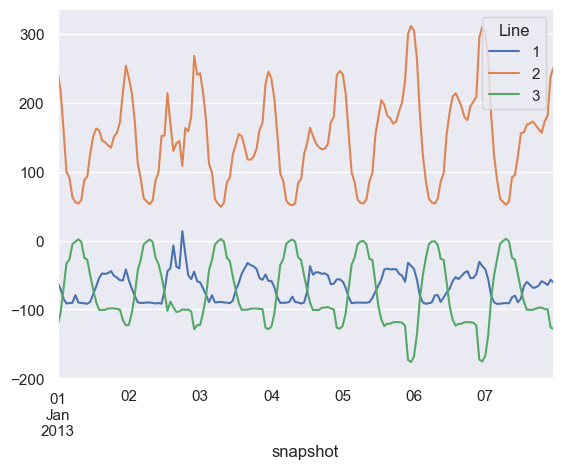

In [38]:
print(type(n.lines_t.p0) and type(n.lines_t.p1))

n.lines_t.p1.loc["2013-01-01":"2013-01-07",:].plot(kind = "line")

### Demand

In [39]:
print(type(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()))

print(n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum())

<class 'pandas.core.series.Series'>
bus
BO 0    1.000000e+09
BO 1    1.000001e+09
BO 2    1.000002e+09
BO 3    1.000000e+09
Name: p_nom_opt, dtype: float64


<AxesSubplot:xlabel='snapshot'>

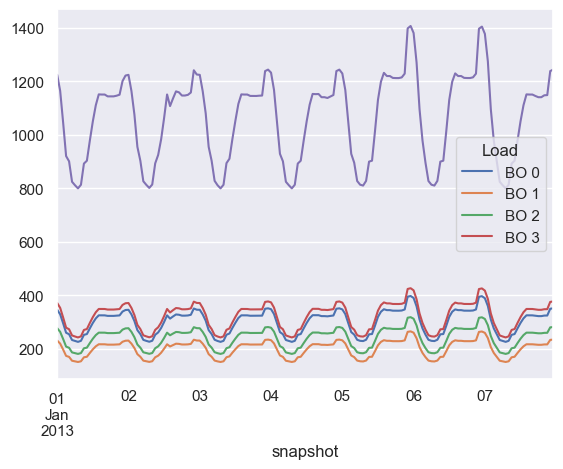

In [40]:
#n.loads_t.p_set.loc["2013-01-01":"2013-12-30","BO0 0"].plot()

n.loads_t.p_set.loc["2013-01-01":"2013-01-07",:].plot()

n.loads_t.p_set.loc["2013-01-01":"2013-01-07",:].sum(axis=1).plot()


Load
BO 0    2.603164e+06
BO 1    1.736468e+06
BO 2    2.084443e+06
BO 3    2.793792e+06
dtype: float64
9217867.62726675


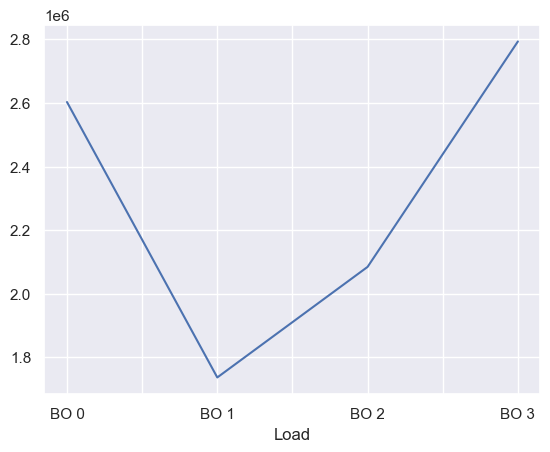

In [41]:
print(n.loads_t.p_set.sum())

n.loads_t.p_set.sum().plot()

print(n.loads_t.p_set.sum().sum())

In [42]:
a = n.loads_t.p_set.sum().rename("load").rename_axis("bus")
a.rename("load", inplace=True)
a.rename_axis("bus", inplace=True)
a

bus
BO 0    2.603164e+06
BO 1    1.736468e+06
BO 2    2.084443e+06
BO 3    2.793792e+06
Name: load, dtype: float64

In [43]:
n.generators.iloc[:, :].groupby(["bus"]).p_nom_opt.sum()

###### potencia maxima?
#n.generators.iloc[:, :].groupby(["bus"]).p_max_pu.sum()

bus
BO 0    1.000000e+09
BO 1    1.000001e+09
BO 2    1.000002e+09
BO 3    1.000000e+09
Name: p_nom_opt, dtype: float64

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


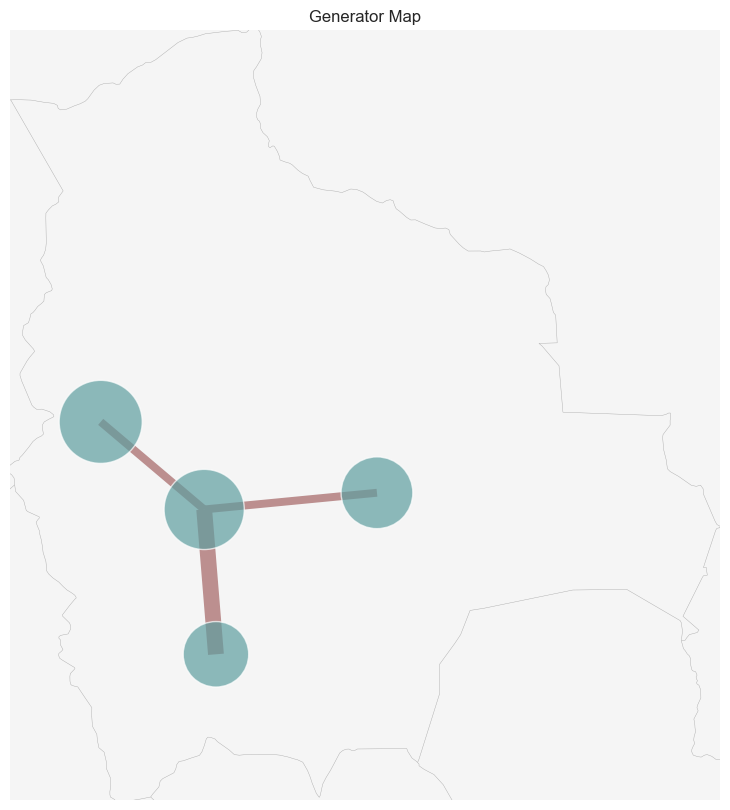

In [44]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
shapes=world[world.name.isin(["Bolivia"])].set_index("name")

fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={
        "projection": ccrs.PlateCarree()
    },  # PlateCarree(default), Mercator, Orthographic
)

# loading = (n3.lines_t.p0.abs().mean().sort_index() / (n3.lines.s_nom_opt*n.lines.s_max_pu).sort_index()).fillna(0.)

n.plot(
    margin=0.1,
    ax=ax,
    geomap=True,  #'10m' leads to a beautiful high resolution map
    projection=None,
    bus_colors="cadetblue",
    bus_alpha=0.7,
    bus_sizes=normalize_node_size(
        n.loads_t.p_set.sum().rename("load").rename_axis("bus")
    )*0.5,  # n.loads_t.p_set.sum().rename("load").rename_axis("bus")*.0000003,
    bus_cmap=None,
    line_colors="rosybrown",
    link_colors="darkseagreen",  # loading
    transformer_colors="orange",
    line_widths=n.lines.s_nom_opt / 1e2,
    link_widths=1.5,
    transformer_widths=1.5,
    line_cmap=None,
    link_cmap=None,  # plt.cm.virdis (colordmap for line loading)
    transformer_cmap=None,
    flow=None,
    branch_components=None,
    layouter=None,
    title="Generator Map",
    boundaries=None,
    geometry=False,
    jitter=None,
    color_geomap=True,
)  # None or True

ax.set_extent([shapes.total_bounds[0], shapes.total_bounds[2],shapes.total_bounds[1], shapes.total_bounds[3]], crs=ccrs.PlateCarree())


In [45]:
# backup
gen_serie = n.generators.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
load_serie = n.loads_t.p_set.sum().rename("load").rename_axis("bus")

load_serie = pd.Series(
    load_serie.values,
    index=pd.MultiIndex.from_tuples([(id, "AC load") for id in load_serie.index]),
)

tot_serie = pd.concat([gen_serie, load_serie])  # .groupby(['bus', 'carrier']).sum()

pd.concat([gen_serie, load_serie])

bus   carrier
BO 0  OCGT       1.499100e+02
      load       1.000000e+09
      onwind     2.654000e+01
      ror        1.323200e+02
      solar      5.020000e+01
BO 1  CCGT       4.543000e+02
      load       1.000000e+09
      onwind     1.693270e-06
      ror        1.904000e+01
      solar      6.470000e+01
BO 2  CCGT       9.096900e+02
      OCGT       7.497600e+02
      biomass    5.064000e+01
      load       1.000000e+09
      onwind     1.706598e-06
      solar      2.257985e-06
BO 3  OCGT       4.925000e+01
      biomass    4.940000e+00
      load       1.000000e+09
      oil        1.174000e+01
      onwind     1.308430e-06
      ror        2.111700e+02
      solar      2.326185e-06
BO 0  AC load    2.603164e+06
BO 1  AC load    1.736468e+06
BO 2  AC load    2.084443e+06
BO 3  AC load    2.793792e+06
dtype: float64

### Plot of Average Marginal Price

c:\Users\Lenovo\anaconda3\envs\pypsa-earth\lib\site-packages\cartopy\mpl\style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


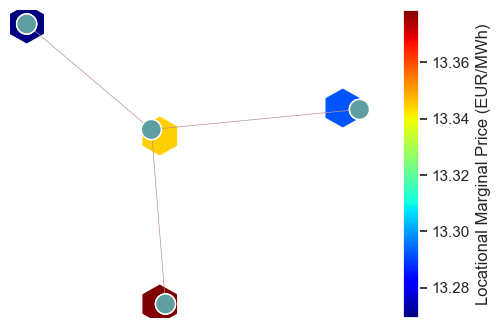

In [46]:
import matplotlib.pyplot as plt
import pypsa
import numpy as np
import cartopy.crs as ccrs

n = n_solve

now = n.snapshots[1800]  ##one specific time

fig, ax = plt.subplots(1, 1, subplot_kw={"projection": ccrs.PlateCarree()})
fig.set_size_inches(7, 4)

n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index))
plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=10,
    # C=n.buses_t.marginal_price.loc[now], #at one time (previous set up by scigrid)
    C=n.buses_t.marginal_price.sum()
    / len(n.snapshots[:]),  # Marginal price averaged over the whole year (My version)
    # - shows in which regions electricity will be cheap and where el. intensive companies should be placed.
    cmap=plt.cm.jet,
)

# for some reason the colorbar only works with graphs plt.plot
# and must be attached plt.colorbar

cb = plt.colorbar()
cb.set_label("Locational Marginal Price (EUR/MWh)")

### Storage

<AxesSubplot:xlabel='snapshot'>

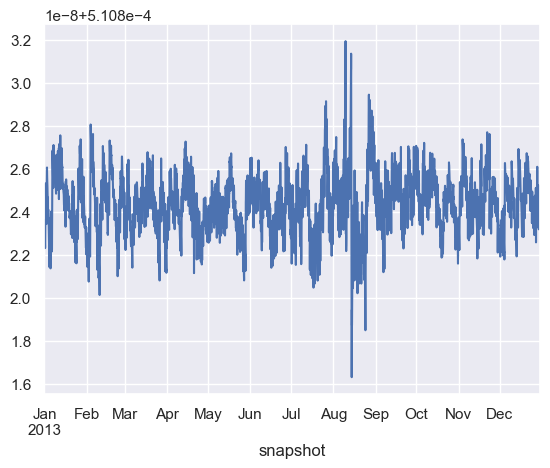

In [47]:
n.stores_t.e.loc["2013-01-01":"2013-12-30"].sum(axis=1).plot()

In [48]:
n.links.iloc[:].groupby(["carrier"]).p_nom_opt.sum()

carrier
H2 electrolysis       0.000014
H2 fuel cell          0.000021
battery charger       0.000033
battery discharger    0.000036
Name: p_nom_opt, dtype: float64

In [49]:
n.stores_t.e.sum()

Store
BO 0 H2         1.065281
BO 1 H2         1.065281
BO 2 H2         1.065281
BO 3 H2         1.065281
BO 0 battery    0.053424
BO 1 battery    0.053424
BO 2 battery    0.053424
BO 3 battery    0.053424
dtype: float64

### Storage_units (hydro reservoir)

In [50]:
n.storage_units

,efficiency_store,carrier,p_nom,cyclic_state_of_charge,max_hours,capital_cost,p_min_pu,efficiency_dispatch,bus,marginal_cost,build_year,p_nom_opt,control,type,p_nom_extendable,p_nom_min,p_nom_max,p_max_pu,p_set,q_set,sign,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BO 0 hydro,0.0,hydro,296.15,True,1300.0,160627.143522,0.0,0.9,BO 0,0.009106,0,296.15,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,inf,0.0,False,NaN,True,0.0,0.0
BO 1 hydro,0.0,hydro,7.46,True,1300.0,160627.143522,0.0,0.9,BO 1,0.009634,0,7.46,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,inf,0.0,False,NaN,True,0.0,0.0
BO 3 hydro,0.0,hydro,66.06,True,1300.0,160627.143522,0.0,0.9,BO 3,0.010037,0,66.06,PQ,,False,0.0,inf,1.0,0.0,0.0,1.0,inf,0.0,False,NaN,True,0.0,0.0


<AxesSubplot:xlabel='snapshot'>

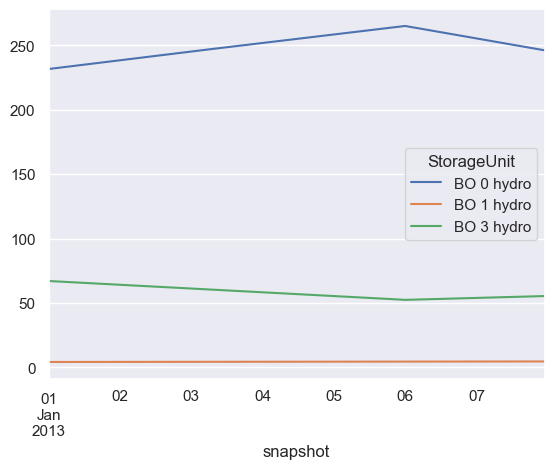

In [51]:

n.storage_units_t.inflow.loc["2013-01-01":"2013-01-07"].plot()

In [52]:
n.storage_units_t.p.loc["2013-01-01":"2013-01-01"].sum(axis=0)

StorageUnit
BO 0 hydro    3797.170620
BO 1 hydro      65.997577
BO 3 hydro     943.115869
dtype: float64

<AxesSubplot:xlabel='snapshot'>

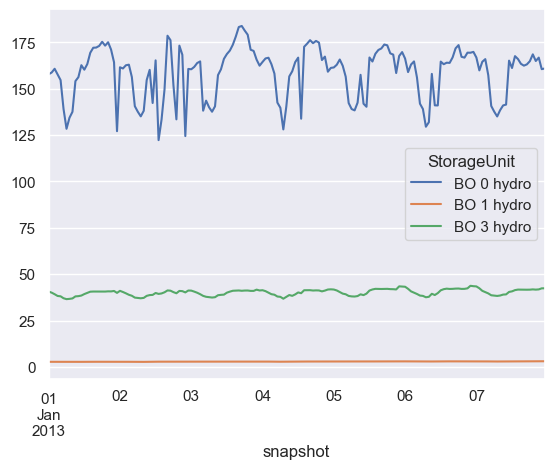

In [53]:
n.storage_units_t.p.loc["2013-01-01":"2013-01-07"].plot()

In [54]:
hydro_serie = n.storage_units.iloc[:, :].groupby(["bus", "carrier"]).p_nom_opt.sum()
hydro_serie

bus   carrier
BO 0  hydro      296.15
BO 1  hydro        7.46
BO 3  hydro       66.06
Name: p_nom_opt, dtype: float64

In [55]:
hydro_serie.sum()

369.67

In [56]:
n.storage_units_t.p.sum().sum()

1300479.936836307

# Plot Load + Generators + Storage_Units

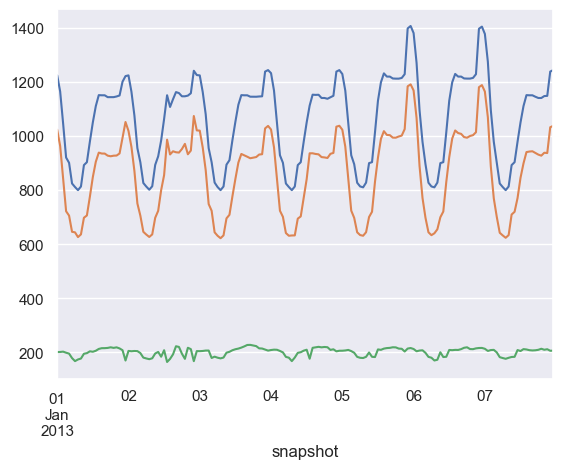

In [57]:
total_load = n.loads_t.p_set.loc["2013-01-01":"2013-01-07",:].sum(axis=1).plot()

gen_units = n.generators_t.p.loc["2013-01-01":"2013-01-07"].sum(axis=1).plot()

res_units = n.storage_units_t.p.loc["2013-01-01":"2013-01-07"].sum(axis=1).plot()

In [58]:
n.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                2.658164e-07         1.545209e+07   
            Combined-Cycle Gas     4.704754e-01         1.152150e+08   
            Oil                    8.023550e-09         4.488738e+05   
            Onshore Wind           6.315307e-02         2.900705e+06   
            Open-Cycle Gas         2.321902e-08         4.482182e+07   
            Run of River           6.547619e-01         9.822414e+07   
            Solar                  2.005279e-01         5.843350e+06   
            load                   1.108586e-14         0.000000e+00   
Line        AC                     1.937617e-01         3.018051e+07   
Link        H2 electrolysis        4.309051e-01         6.806147e-01   
            H2 fuel cell           2.329031e-01         5.049530e-01   
            battery charger        4.202773e-01         1.255356e+00   
            battery discharger     3.404246e-01         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam        4.015923e-01         5.937904e+07   
Store       Battery Storage        5.000000e-01         7.746720e-01   
            Hydrogen Storage       4.999999e-01         7.746721e-01   

                                Curtailment  Installed Capacity  \
            carrier                                               
Generator   Biomass                0.000000        5.558000e+01   
            Combined-Cycle Gas     0.000000        1.363990e+03   
            Oil                    0.000000        1.174000e+01   
            Onshore Wind           0.000032        2.654000e+01   
            Open-Cycle Gas         0.000000        9.489200e+02   
            Run of River           0.000003        3.625300e+02   
            Solar                  0.000008        1.149000e+02   
            load                   0.000000        4.000000e+09   
Line        AC                          NaN        3.932448e+03   
Link        H2 electrolysis             NaN        0.000000e+00   
            H2 fuel cell                NaN        0.000000e+00   
            battery charger             NaN        0.000000e+00   
            battery discharger          NaN        0.000000e+00   
Load        -                           NaN                 NaN   
StorageUnit Reservoir & Dam        0.000000        3.696700e+02   
Store       Battery Storage             NaN        0.000000e+00   
            Hydrogen Storage            NaN        0.000000e+00   

                                Operational Expenditure  Optimal Capacity  \
            carrier                                                         
Generator   Biomass                        2.211289e-04      5.558000e+01   
            Combined-Cycle Gas             8.271929e+03      1.363990e+03   
            Oil                            1.226777e-05      1.174000e+01   
            Onshore Wind                   4.141658e-02      2.654000e+01   
            Open-Cycle Gas                 3.171660e-04      9.489200e+02   
            Run of River                   2.517419e+00      3.625300e+02   
            Solar                          4.491042e-01      1.149000e+02   
            load                           4.478554e-05      4.000000e+09   
Line        AC                                      NaN      2.276681e+03   
Link        H2 electrolysis                0.000000e+00      1.394862e-05   
            H2 fuel cell                   0.000000e+00      2.064560e-05   
            battery charger                0.000000e+00      3.260011e-05   
            battery discharger             0.000000e+00      3.622234e-05   
Load        -                                       NaN               NaN   
StorageUnit Reservoir & Dam                1.375103e+00      3.696700e+02   
Store       Battery Storage               -5.532833e-31      4.878937e-05   
   